In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import gym
import matplotlib.pyplot as plt


gamma = 0.99  
epsilon = 1.0  
epsilon_min = 0.1  
epsilon_max = 1.0  
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  
max_steps_per_episode = 10000
env = gym.make('Breakout-v4',render_mode='rgb_array')
num_actions = env.action_space.n


In [2]:
color = np.array([210, 164, 74]).mean()

def preprocess_state(state):

    image = state[1:176:2, ::2]

    #convert the image to greyscale
    image = image.mean(axis=2)

    #improve image contrast
    image[image==color] = 0

    #normalize the image
    image = (image - 128) / 128 - 1

    return image


In [3]:
num_actions = 4


def create_q_model():
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=(88, 80, 1,))

    # Convolutions on the frames on the screen
    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(512, activation="relu")(layer4)
    action = layers.Dense(num_actions, activation="linear")(layer5)

    return keras.Model(inputs=inputs, outputs=action)


model = create_q_model()

model_target = create_q_model()


In [4]:
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0

epsilon_greedy_frames = 1000000.0

update_target_network = 10000
# Using huber loss for stability
loss_function = keras.losses.Huber()
loss_history = []

running_reward_history = []

while True:  
    env.reset()
    state = preprocess_state(env.render())
    episode_reward = 0
    

    for timestep in range(max_steps_per_episode):
        
        frame_count += 1
        if epsilon > np.random.rand(1)[0]:
            
            action = np.random.choice(num_actions)
        else:
            
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            
            action = tf.argmax(action_probs[0]).numpy()

        
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)

        
        state_next, reward, done, _, _ = env.step(action)
        state_next = preprocess_state(state_next)

        episode_reward += reward

        
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        
        if len(done_history) > batch_size:
            
            
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # In DDQN, we use the main value network for action selection and the target network for outputting the Q values.
            future_rewards = model.predict(state_next_sample, verbose=0)  # Predicting q-values of nest states using main network
            best_action = tf.argmax(future_rewards, axis=1) # Choosing the action with maximum q-value

            qvalue_best_action = model_target.predict(state_next_sample, verbose=0) # Predicting the q-values of next states using target network

            best_qvalue_best_action = []
            for i in range(0, len(best_action)):
                best_qvalue_best_action.append(qvalue_best_action[i][best_action[i]]) # Selecting the q-value of the action selecting using main network
            best_qvalue_best_action = np.array(best_qvalue_best_action)

            updated_q_values = rewards_sample + gamma * best_qvalue_best_action
         
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                
                q_values = model(state_sample)
              
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                
                loss = loss_function(updated_q_values, q_action)

            loss_history.append(loss)

            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:         
            model_target.set_weights(model.get_weights())
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))


        if done:
            break
            
    episode_reward_history.append(episode_reward)
    running_reward = np.mean(episode_reward_history)
    running_reward_history.append(running_reward)

    episode_count += 1
    
    

    if episode_count > 250:
        print("Solved at episode {}!".format(episode_count))
        break

c:\Python39\lib\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


running reward: 1.92 at episode 36, frame count 10000


Text(0, 0.5, 'Reward')

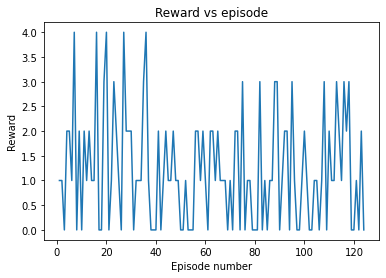

In [ ]:
episodes = [i for i in range(1, episode_count+1)]
plt.plot(episodes, episode_reward_history)
plt.title("Reward vs episode")
plt.xlabel("Episode number")
plt.ylabel("Reward")

Text(0, 0.5, 'Loss')

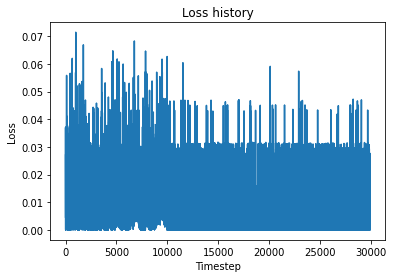

In [ ]:
x_axis = [i for i in range(1, len(loss_history)+1)]
plt.plot(x_axis, loss_history)
plt.title("Loss history")
plt.xlabel("Timestep")
plt.ylabel("Loss")

In [ ]:
# Plotting rewards vs episodes for analyzing the results
x_axis = [i for i in range(1, len(running_reward_history)+1)]
plt.plot(x_axis, running_reward_history)
plt.title("Running Reward history")
plt.xlabel("Timestep")
plt.ylabel("Running Reward")

NameError: name 'running_reward_history' is not defined